## Lab 7: Heart Attack

In [247]:
#| echo: false
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, auc, f1_score, cohen_kappa_score

In [95]:
data = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
data = data.dropna()
data.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [250]:
X = data.drop("output", axis = 1)
y = data["output"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Part 1: Fitting Models & Part 2: Metrics

#### 1.1 KNN

In [249]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), ["sex", "cp", "restecg"]),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ]
)

my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("KNN", KNeighborsClassifier())
    ]
)

alphas = {"KNN__n_neighbors": list(range(1, 25))}

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='roc_auc')
gscv_fitted = gscv.fit(X, y)
test_scores = gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16b0bc8d0>)])),
                ('KNN', KNeighborsClassifier(n_neighbors=22))])

In [125]:
print(f"Average ROC AUC across 25 cross validations: {np.mean(test_scores)}\nThis is a score that is significantly better than random guesses.")

Average ROC AUC across 25 cross validations: 0.6469249631594459
This is a score that is significantly better than random guesses.


In [251]:
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("KNN", KNeighborsClassifier(n_neighbors=22))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

y_pred = fitted_pipeline.predict(X_test)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_prob)

In [97]:
cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,24,7
Actual Risk,9,29


#### 2.1 KNN Metrics

In [253]:
rec = recall_score(y_true = y_test, y_pred = y_pred)
prec = precision_score(y_true = y_test, y_pred = y_pred)
f1 = f1_score(y_true = y_test, y_pred = y_pred)
kappa_knn = cohen_kappa_score(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1}")

Recall Score: 0.7368421052631579 
Precision Score: 0.717948717948718 
Specificity Score: 0.6451612903225806 
F1 Score: 0.7272727272727273


#### 1.2 Logistic Regression

In [133]:
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Logistic Regression", LogisticRegression(solver="saga", max_iter=1000))
    ]
)

alphas = {
    "Logistic Regression__penalty": ["elasticnet"],
    "Logistic Regression__l1_ratio": [.0001, .001, .01, .1, 1],
    "Logistic Regression__C": list(range(1, 10))
}

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='roc_auc')
gscv_fitted = gscv.fit(X, y)
test_scores = gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16abfd310>)])),
                ('Logistic Regression',
                 LogisticRegression(C=5, l1_ratio=0.001, max_iter=1000,
                                    penalty='elasticnet', solver='saga'))])

In [134]:
print(f"Average ROC AUC across 25 cross validations: {np.mean(test_scores)}\nThis is a score that is significantly better than random guesses.")

Average ROC AUC across 25 cross validations: 0.8634054582964927
This is a score that is significantly better than random guesses.


In [254]:
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Logistic Regression", LogisticRegression(solver="saga", C=5, l1_ratio=.001, penalty = "elasticnet", max_iter = 1000))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

y_pred = fitted_pipeline.predict(X_test)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_test)[:, 1]
fpr_logis, tpr_logis, thresholds = roc_curve(y_test, y_prob)

In [92]:
cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,26,5
Actual Risk,7,31


In [100]:
# Interpret Coefficients 
coefs = fitted_pipeline.named_steps["Logistic Regression"].coef_[0]
coefs = dict(zip(X.columns, coefs))
sorted_coef = dict(sorted(coefs.items(), key=lambda item: item[1]))
sorted_coef

{'trtbps': -0.6128300343465976,
 'age': -0.3508237686611326,
 'restecg': -0.2551513282898318,
 'thalach': -0.19112777677485696,
 'chol': 0.42861417012637526,
 'cp': 0.617888314032257,
 'sex': 1.288210459447763}

Examining the coefficients from the logistic regression, we see that the most influential variables for predicting the likelihood of a person experiencing an exercise-induced heart attack are the sex of the person, the type of chest pain, and the resting blood pressure.

2.2 Logistic Regression Metrics

In [255]:
rec = recall_score(y_true = y_test, y_pred = y_pred)
prec = precision_score(y_true = y_test, y_pred = y_pred)
f1 = f1_score(y_true = y_test, y_pred = y_pred)
kappa_logistic = cohen_kappa_score(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1}")

Recall Score: 0.7631578947368421 
Precision Score: 0.7073170731707317 
Specificity Score: 0.6129032258064516 
F1 Score: 0.7341772151898733


#### 1.3 Decision Tree

In [136]:
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Decision Tree", DecisionTreeClassifier())
    ]
)

alphas = {"Decision Tree__ccp_alpha": [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='roc_auc')
gscv_fitted = gscv.fit(X, y)
test_scores = gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1691ea690>)])),
                ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.1))])

In [138]:
print(f"Average ROC AUC across 25 cross validations: {np.mean(test_scores)}\nThis is a score that is slightly better than random guesses.")

Average ROC AUC across 25 cross validations: 0.6464015325670497
This is a score that is slightly better than random guesses.


In [257]:
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Decision Tree", DecisionTreeClassifier(ccp_alpha=.1))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

y_pred = fitted_pipeline.predict(X_test)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_prob)

In [112]:
cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,21,10
Actual Risk,8,30


2.3 Decision Tree Metrics

In [258]:
rec = recall_score(y_true = y_test, y_pred = y_pred)
prec = precision_score(y_true = y_test, y_pred = y_pred)
f1 = f1_score(y_true = y_test, y_pred = y_pred)
kappa_dtree = cohen_kappa_score(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1}")

Recall Score: 0.7368421052631579 
Precision Score: 0.6829268292682927 
Specificity Score: 0.5806451612903226 
F1 Score: 0.7088607594936709


#### 1.4 Interpretation
The most important variables for predicting heart attack risk are the sex of the person, the type of chest pain, the resting blood pressure, cholesterol level, and age.

#### 1.5 ROC Curve

In [193]:
fpr = [*fpr_knn, *fpr_logis, *fpr_dt]
tpr = [*tpr_knn, *tpr_logis, *tpr_dt]

In [211]:
roc_df = pd.DataFrame(
    {'False Positive Rate': fpr,
     'True Positive Rate': tpr,
     "Model Type": ["KNN" for _ in range(len(fpr_knn))] + ["Logistic" for _ in range(len(fpr_logis))] + ["Decision Tree" for _ in range(len(fpr_dt))]}
)

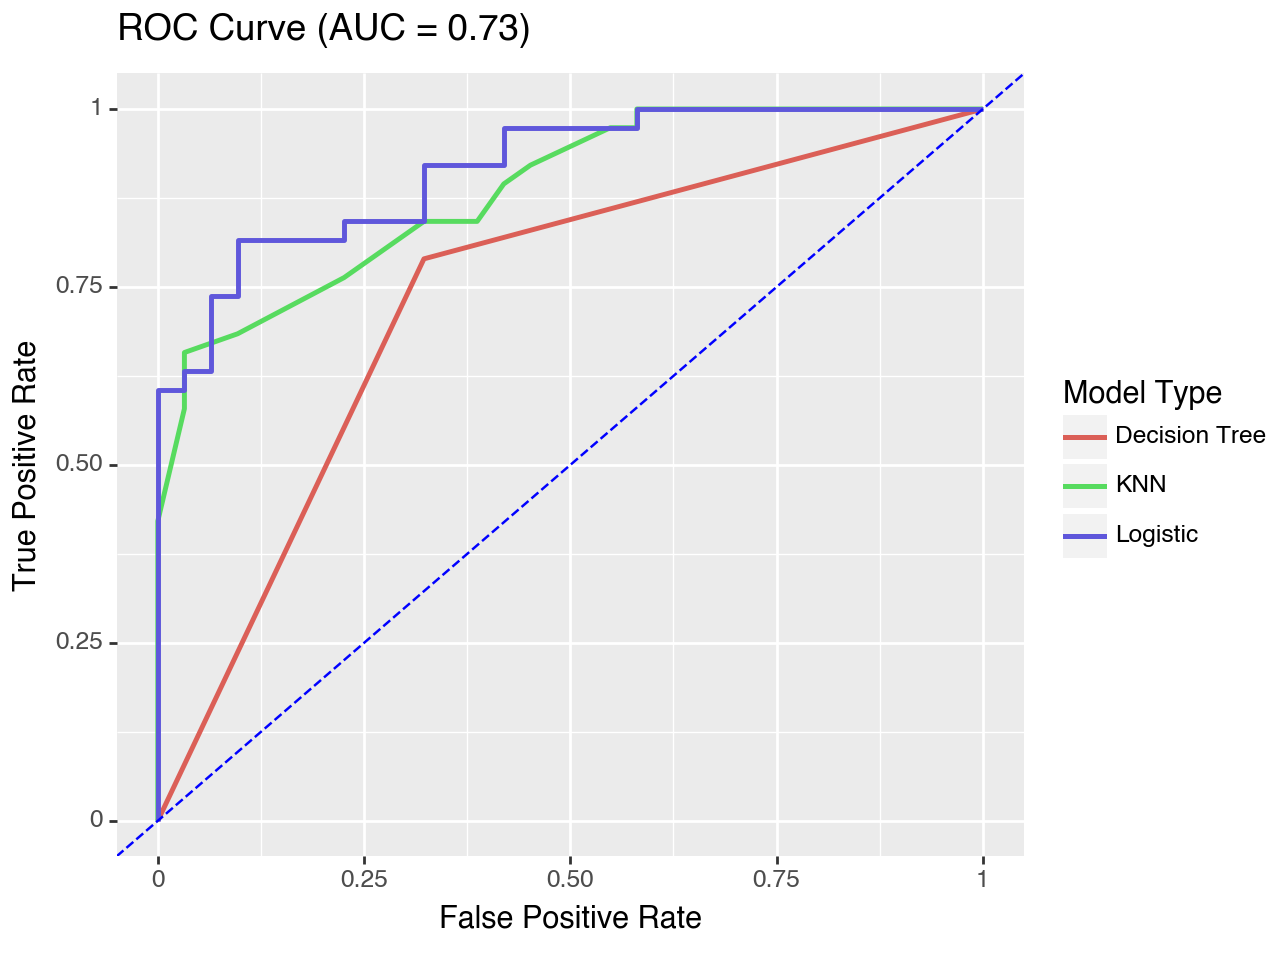

<Figure Size: (640 x 480)>

In [216]:
from plotnine import ggplot, aes, geom_line, geom_abline, labs
(ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate')) +
 geom_line(aes(color = "Model Type"), size = 1) +
 geom_abline(intercept=0, slope=1, linetype='--', color='blue', size=.5) +
 labs(title=f'ROC Curve (AUC = {roc_auc:.2f})', x='False Positive Rate', y='True Positive Rate'))

## Part 3: Discussion

#### Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

The hospital will want to minimize the chance of a false negatives, therefore they will want to prioritize recall. A higher recall score indicates that the model is better at correctly identifying patients at risk of a heart attack. For this scenario I would recommend model 2, the logistic regression model, as it has the highest recall score of the three models. I would expect a recall score of about .8 for future observations.

#### Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

In this scenario, the hospital is concerned about the usage of space and thus would want to avoid false positives (patients wrongly classified as high risk). Therefore, I would recommend using specificity as the metric for model selection, along with recall score for further selection, as the goal would be to avoid false positives. For this scenario, I would recommend recommend model 2, the logistic regression model, as it has the highest specificity score and the highest recall score of the three models. I would expect a specificity score of about .84 and a recall score of about .8 for future observations. 

#### Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

For a study on root causes, interpretability and feature importance are critical. Therefore you would want to use metrics that allow for clear interpretation, like ROC-AUC and precision. Due to the desire of interpretability, the best model will be model 2, the logistic regression model, as the model has interpretable coefficients. Model 2 also has the best precision and ROC-AUC scores. I would expect a precision score of about .86 and a ROC-AUC score of about .86 for future observations.

#### Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

When testing a new batch of doctors against the model on their ability to diagnose patients, a good metric to use would be F1 score as it measures overall classification performance. The model with the best F1 score is model 2, the logistic regression model. I would expect a F1 score of about .84 for future observations.

## Part 4: Validation

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?


In [225]:
data_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
data_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [226]:
X_validation = data_validation.drop("output", axis = 1)
y_validation = data_validation["output"]

In [245]:
# KNN
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("KNN", KNeighborsClassifier(n_neighbors=22))
    ]
)

fitted_pipeline = my_pipeline.fit(X, y)

y_pred = fitted_pipeline.predict(X_validation)

cm = confusion_matrix(y_true = y_validation, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_validation)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_validation, y_prob)

cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,10,1
Actual Risk,7,12


In [246]:
rec = recall_score(y_true = y_validation, y_pred = y_pred)
prec = precision_score(y_true = y_validation, y_pred = y_pred)
f1 = f1_score(y_true = y_validation, y_pred = y_pred)
roc_auc = roc_auc_score(y_true = y_validation, y_score = y_prob)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1} \nROC_AUC Score: {roc_auc}")

Recall Score: 0.631578947368421 
Precision Score: 0.9230769230769231 
Specificity Score: 0.9090909090909091 
F1 Score: 0.7499999999999999 
ROC_AUC Score: 0.9186602870813397


In [243]:
# Logistic Regression
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Logistic Regression", LogisticRegression(solver="saga", C=5, l1_ratio=.001, penalty = "elasticnet", max_iter = 1000))
    ]
)

fitted_pipeline = my_pipeline.fit(X, y)

y_pred = fitted_pipeline.predict(X_validation)

cm = confusion_matrix(y_true = y_validation, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_validation)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_validation, y_prob)

cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,8,3
Actual Risk,5,14


In [244]:
rec = recall_score(y_true = y_validation, y_pred = y_pred)
prec = precision_score(y_true = y_validation, y_pred = y_pred)
f1 = f1_score(y_true = y_validation, y_pred = y_pred)
roc_auc = roc_auc_score(y_true = y_validation, y_score = y_prob)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1} \nROC_AUC Score: {roc_auc}")

Recall Score: 0.7368421052631579 
Precision Score: 0.8235294117647058 
Specificity Score: 0.7272727272727273 
F1 Score: 0.7777777777777778 
ROC_AUC Score: 0.8851674641148326


In [241]:
# Decision Tree 
my_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("Decision Tree", DecisionTreeClassifier(ccp_alpha=.1))
    ]
)

fitted_pipeline = my_pipeline.fit(X, y)

y_pred = fitted_pipeline.predict(X_validation)

cm = confusion_matrix(y_true = y_validation, y_pred = y_pred)

cm_df = pd.DataFrame(cm, index=['Actual No Risk', 'Actual Risk'], columns=['Predicted No Risk', 'Predicted Risk'])

y_prob = fitted_pipeline.predict_proba(X_validation)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_validation, y_prob)

cm_df

,Predicted No Risk,Predicted Risk
Actual No Risk,10,1
Actual Risk,5,14


In [242]:
rec = recall_score(y_true = y_validation, y_pred = y_pred)
prec = precision_score(y_true = y_validation, y_pred = y_pred)
f1 = f1_score(y_true = y_validation, y_pred = y_pred)
roc_auc = roc_auc_score(y_true = y_validation, y_score = y_prob)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print(f"Recall Score: {rec} \nPrecision Score: {prec} \nSpecificity Score: {spec} \nF1 Score: {f1} \nROC_AUC Score: {roc_auc}")

Recall Score: 0.7368421052631579 
Precision Score: 0.9333333333333333 
Specificity Score: 0.9090909090909091 
F1 Score: 0.8235294117647058 
ROC_AUC Score: 0.8229665071770335


Comparing the models to the cross validated metrics, I found that for KNN all of the metrics except the recall score and F1 score are significantly better than expected from earlier in the cross validation metrics. For the logistic regression model, I found that all of the metrics except for ROC AUC are worse than expeceted from earlier in the cross validation metrics, with ROC AUC being very similar to the predicted value. Finally, for the Decision Tree model, I found that the recall score is worse while all of the other metrics are significantly better than expected from the cross validation metrics.

## Part 5: Cohen's Kappa

In [259]:
print(f"Cohen's Kappa Scores \nKNN: {kappa_knn} \nLogistic Regression: {kappa_logistic} \nDecision Tree: {kappa_dtree}")

Cohen's Kappa Scores 
KNN: 0.3831417624521072 
Logistic Regression: 0.37944325481798724 
Decision Tree: 0.3203426124197003


Cohen's Kappa is useful as a measure of model success in situations where the distribution of classes is imbalanced. In imbalanced datasets, accuracy by itself may not be a good indicator of model performance. Cohen's Kappa considers the agreement beyond chance and adjusts for the class distribution, providing a more robust measure of performance. Another scenario where Cohen's Kappa might be beneficial is assessing the performance of models in tasks involving people, such as medical diagnosis or sentiment analysis, where different people might have varying levels of agreement. This is because Cohen's Kappa accounts for the possibility of agreement occurring by chance, making it is a good metric for evaluating the reliability of classification tasks involving different raters. Examining the values calculated for Cohen's Kappa for my three models does change slightly when using Cohen's Kappa. This is because Cohen's Kappa suggests that the KNN model is slightly better than the logistic regression model. This is backed up by the validation metrics, but is not what I predicted earlier in the lab. I believe this makes sense because we are using medical diagnosis risk data which is an area where people may have different levels of agreement on a diagnosis.